In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import os
import glob

In [ ]:
#!unzip '/content/images.zip'

In [490]:
def display_images(images, cols = 4, rows = 7, cmap=None):
    """Display a list of images in a single figure with matplotlib."""
    plt.figure(figsize=(13, 14))
    for i, image in enumerate(images):
        plt.subplot(rows, cols, i+1)
        #Use gray scale color map if there is only one channel
        cmap = 'gray' if len(image.shape) == 2 else cmap
        plt.imshow(image, cmap = cmap)
        cv2.imwrite('/content/drive/MyDrive/A4_CV/output/'+str(i)+'.jpg', image)
        plt.xticks([])
        plt.yticks([])
    plt.tight_layout(pad=0.5)
    plt.show()
    

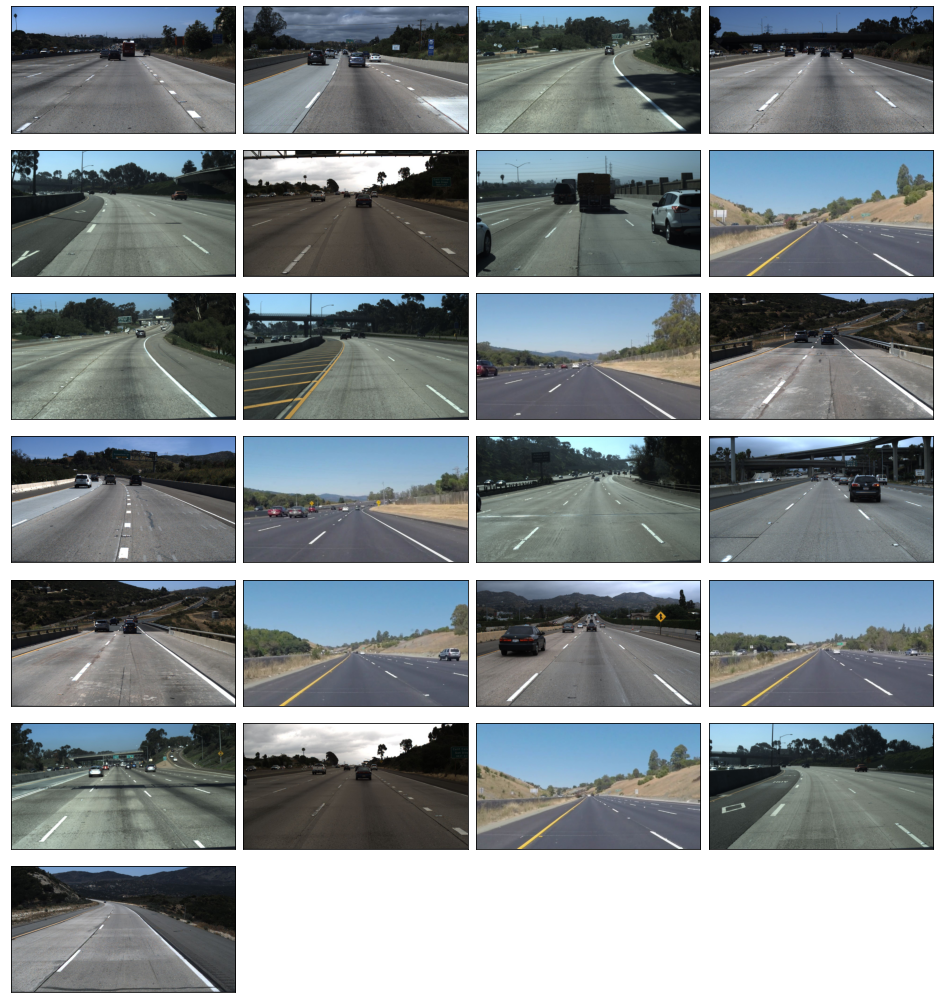

In [462]:
test_images = []
files = [f for f in glob.glob('/content/images/*.jpg')]
#print(files)

for img in files[:]:
  test_images.append(plt.imread(img))

display_images(test_images)

**Covert RGB to HSV**

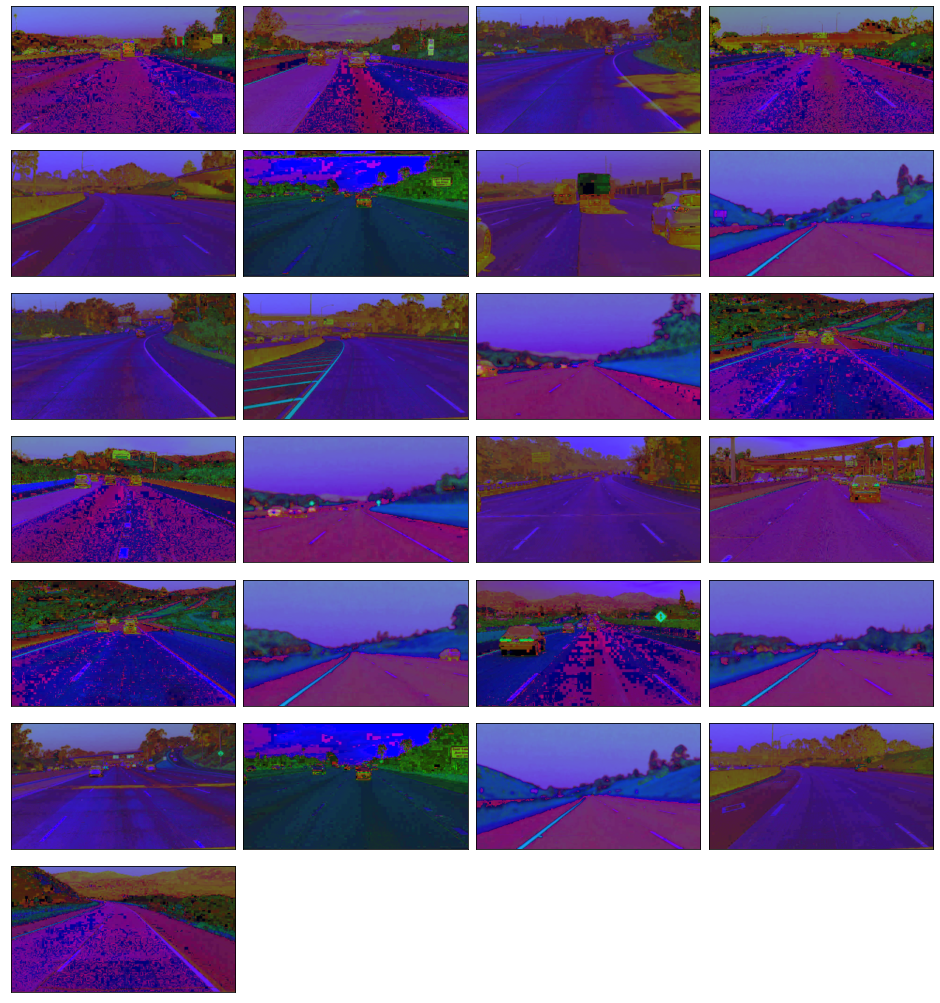

In [475]:
def convert_hsv(image):
    return cv2.cvtColor(image, cv2.COLOR_RGB2HSV)

'''map() is a built-in function that
allows you to process and transform all the items in an iterable without using an explicit for loop'''
#Convert the input image to HSV
converted_image = list(map(convert_hsv, test_images))
display_images(converted_image) 

**Noise Removal**

In [476]:
#Gaussian blur to reduce noise and smoothen the image
def gauss(image):
  return cv2.GaussianBlur(image,(13,13),0)

clean_image = list(map(gauss, converted_image))

**Filter Out White and Yellow lanes**

In [477]:
def HSV_color_masks(image):
    """
    Apply color selection to the HSV images to blackout everything except for white and yellow lane lines.
        Parameters:
            image: An np.array compatible with plt.imshow.
    """

    #Convert the input image to HSV
    hsv_image = convert_hsv(image)

    #remove noise
    converted_image = gauss(hsv_image)

    #White color mask
    lower_threshold = np.uint8([0, 0, 200])
    upper_threshold = np.uint8([255, 30, 255])
    white_mask = cv2.inRange(converted_image, lower_threshold, upper_threshold)
    
    #Yellow color mask
    lower_threshold = np.uint8([10, 100, 0])
    upper_threshold = np.uint8([50, 255, 255])
    yellow_mask = cv2.inRange(converted_image, lower_threshold, upper_threshold)
    
    #Combine white and yellow masks
    mask = cv2.bitwise_or(white_mask, yellow_mask)
    masked_image = cv2.bitwise_and(image, image, mask = mask)
    
    return masked_image

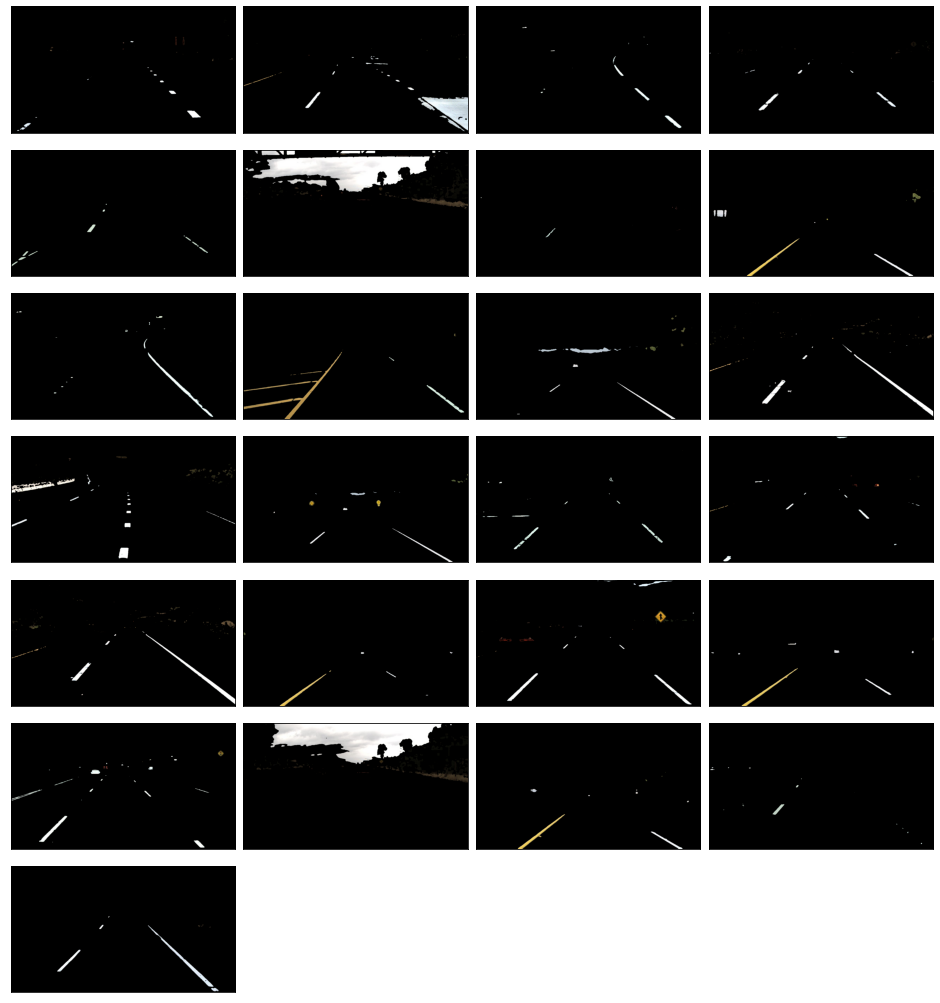

In [479]:
selected_images = list(map(HSV_color_masks, test_images))
display_images(selected_images)


**Canny Edge Detection**

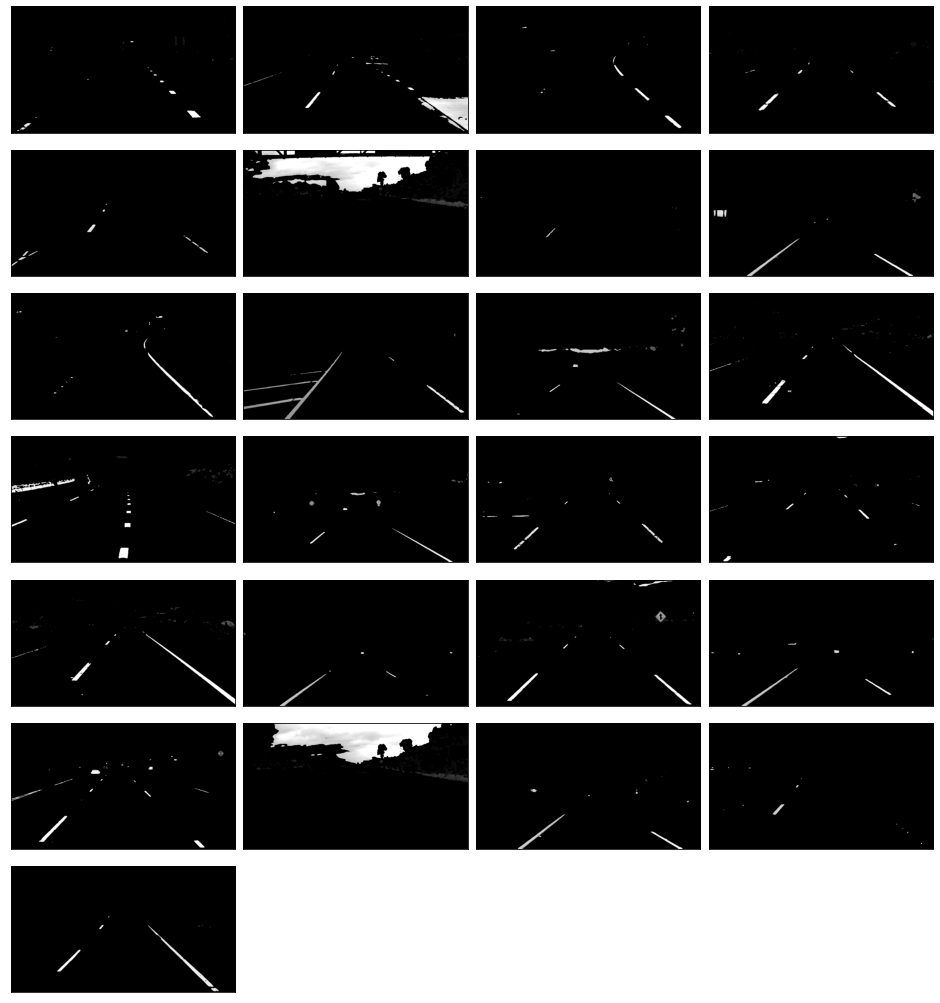

In [482]:
def gray_scale(image):
    return cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

gray_images = list(map(gray_scale, selected_images))

display_images(gray_images)

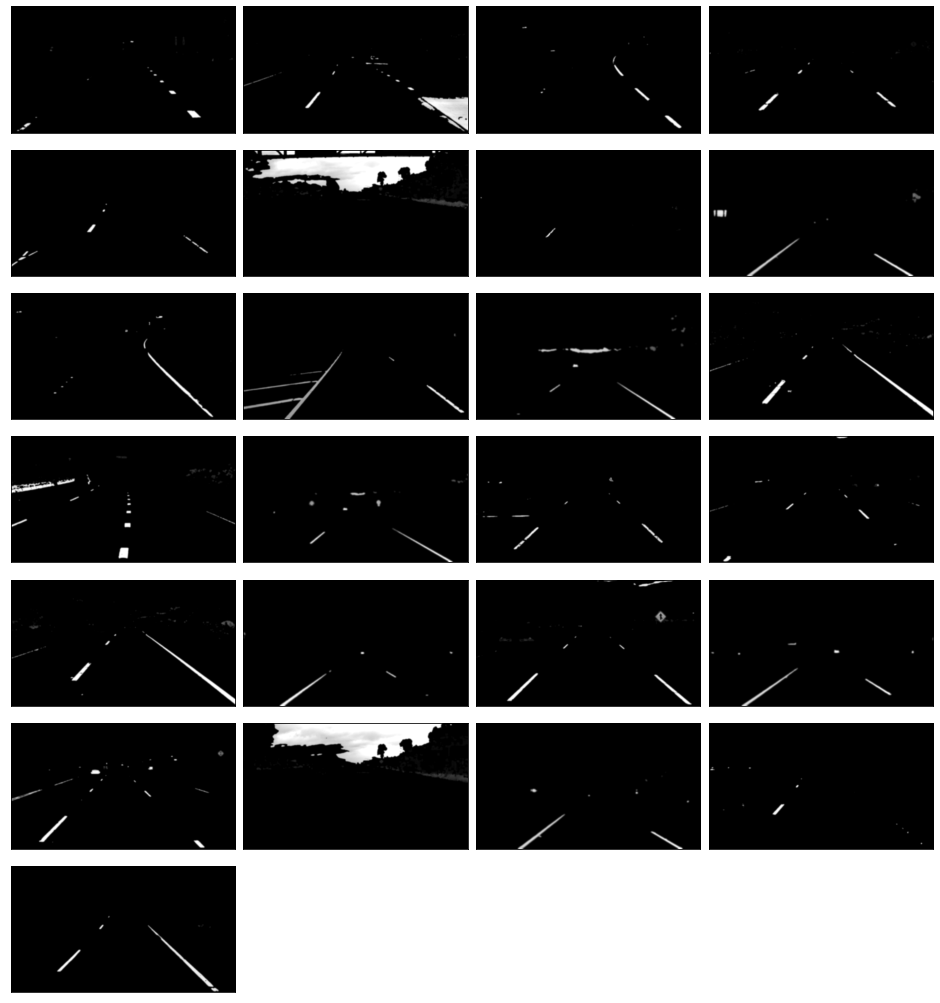

In [194]:
smooth_images = list(map(gauss, gray_images))
display_images(smooth_images)

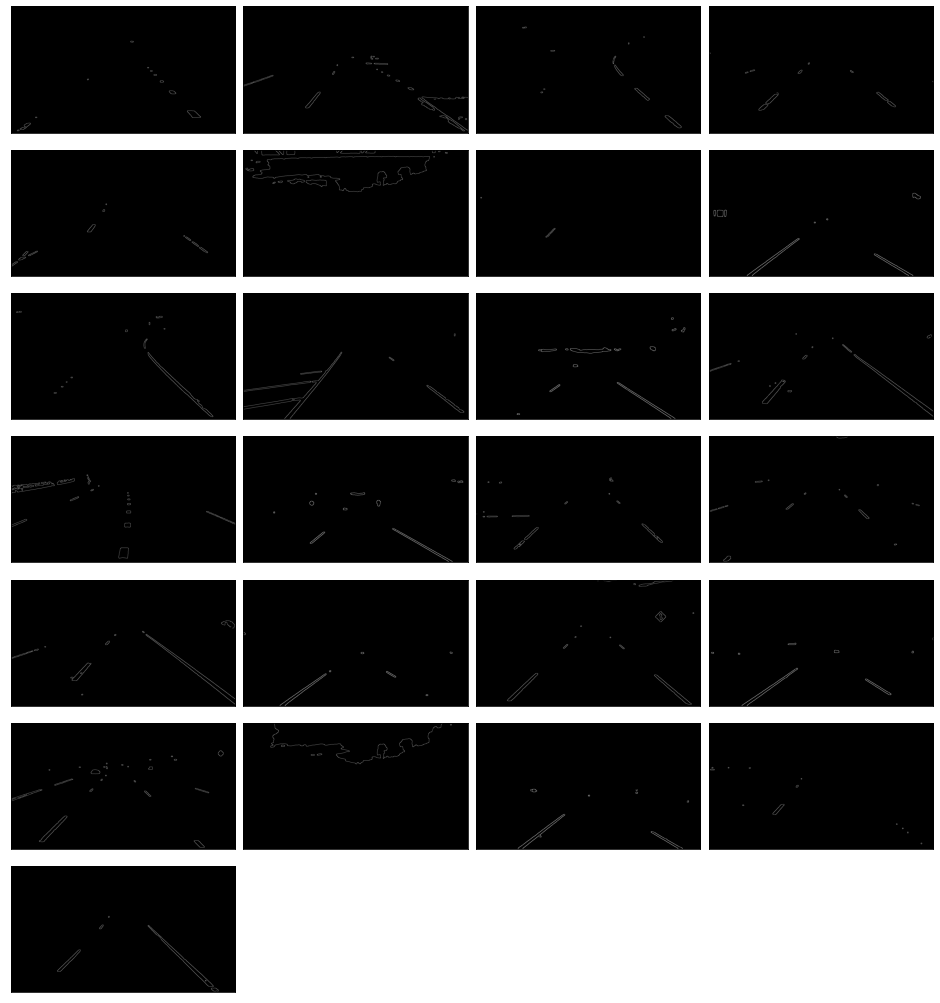

In [483]:
def detect_edges(image, low_threshold=50, high_threshold=150):
    return cv2.Canny(image, low_threshold, high_threshold)

edge_images = list(map(lambda image: detect_edges(image), smooth_images))

display_images(edge_images)

**Region of Interest**

In [485]:
def filter_region(image, vertices):
    """
    Create the mask using the vertices and apply it to the input image
    """
    mask = np.zeros_like(image)

    if len(mask.shape)==2:
        cv2.fillPoly(mask, vertices, 255)
    else:
        cv2.fillPoly(mask, vertices, (255,)*mask.shape[2]) # in case, the input image has a channel dimension        
    return cv2.bitwise_and(image, mask)
    
def select_region(image):
    """
    It keeps the region surrounded by the `vertices` (i.e. polygon).  Other area is set to 0 (black).
    """
    # first, define the polygon by vertices
    rows, cols = image.shape[:2]
    bottom_left  = [cols * 0.1, rows * 0.95]
    top_left     = [cols * 0.4, rows * 0.6]
    bottom_right = [cols * 0.9, rows * 0.95]
    top_right    = [cols * 0.6, rows * 0.6]
    vertices = np.array([[bottom_left, top_left, top_right, bottom_right]], dtype=np.int32)
    # the vertices are an array of polygons (i.e array of arrays) and the data type must be integer

    return filter_region(image, vertices)

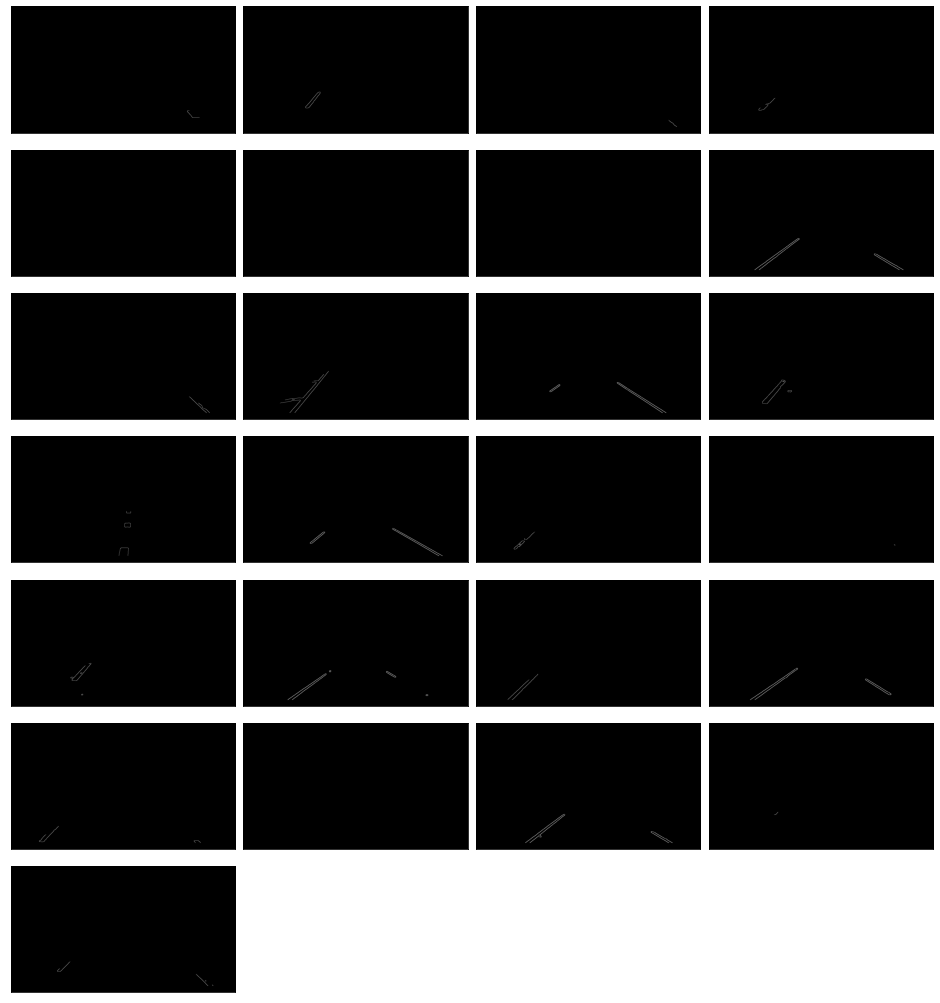

In [486]:
# images showing the region of interest only
roi_images = list(map(select_region, edge_images))
display_images(roi_images)

In [487]:
def hough_lines(image):
    return cv2.HoughLinesP(image, rho=1, theta=np.pi/180, threshold=20, minLineLength=20, maxLineGap=300)


list_of_lines = list(map(hough_lines, roi_images))

In [ ]:
print(list_of_lines)

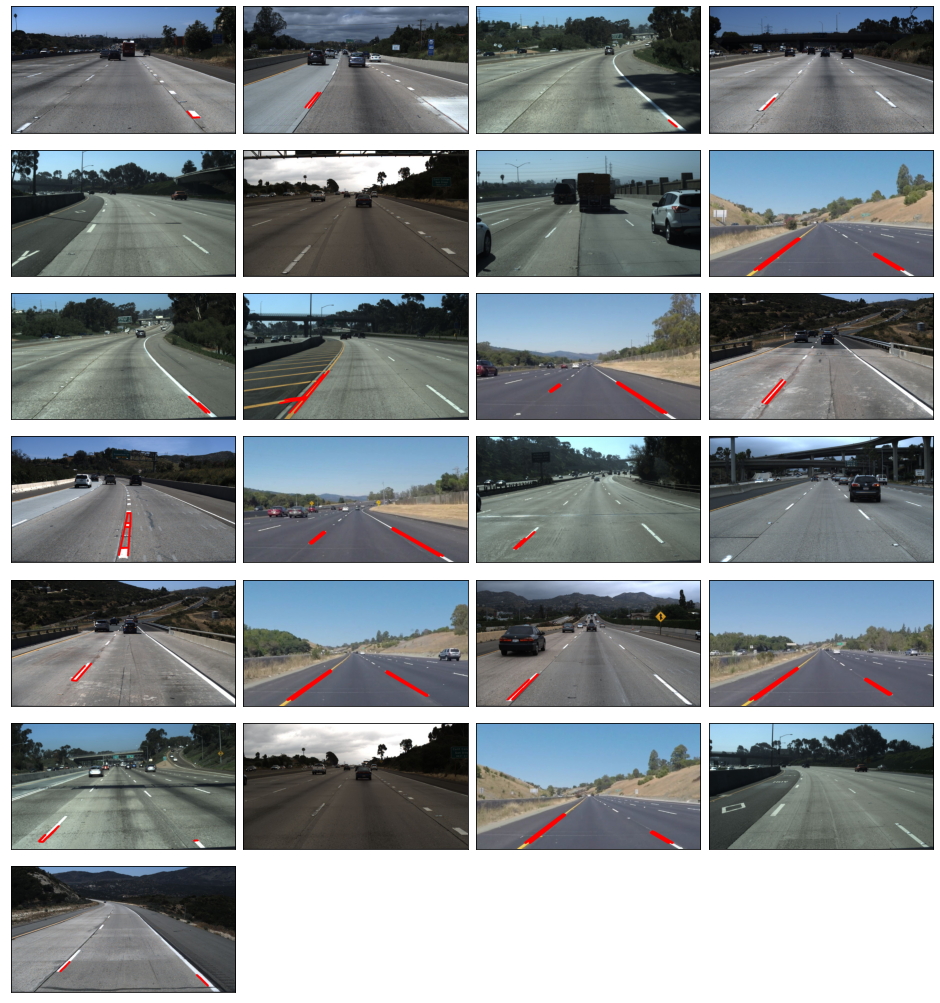

In [489]:
def draw_lines(image, lines, color=[255, 0, 0], thickness=10, make_copy=True):
    if make_copy:
        image = np.copy(image) # don't want to modify the original
    if lines is not None:    
      for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(image, (x1, y1), (x2, y2), color, thickness)
    return image


line_images = []
for image, lines in zip(test_images, list_of_lines):
    line_images.append(draw_lines(image, lines))
    
display_images(line_images)


In [491]:
def average_slope_intercept(lines):
    left_lines    = [] # (slope, intercept)
    left_weights  = [] # (length,)
    right_lines   = [] # (slope, intercept)
    right_weights = [] # (length,)
    if lines is not None:
      for line in lines:
        for x1, y1, x2, y2 in line:
            if x2==x1:
                continue # ignore a vertical line
            slope = (y2-y1)/(x2-x1)
            intercept = y1 - slope*x1
            length = np.sqrt((y2-y1)**2+(x2-x1)**2)
            if slope < 0: # y is reversed in image
                left_lines.append((slope, intercept))
                left_weights.append((length))
            else:
                right_lines.append((slope, intercept))
                right_weights.append((length))
    
    # add more weight to longer lines    
    left_lane  = np.dot(left_weights,  left_lines) /np.sum(left_weights)  if len(left_weights) >0 else None
    right_lane = np.dot(right_weights, right_lines)/np.sum(right_weights) if len(right_weights)>0 else None
    
    return left_lane, right_lane # (slope, intercept), (slope, intercept)

In [492]:
def make_points(y1, y2, line):
    """
    Convert a line represented in slope and intercept into pixel points
    """
    if line is None:
        return None
  
    slope, intercept = line
    
    x1 = int((y1 - intercept)/slope)
    x2 = int((y2 - intercept)/slope)
    y1 = int(y1)
    y2 = int(y2)
    
    return ((x1, y1), (x2, y2))

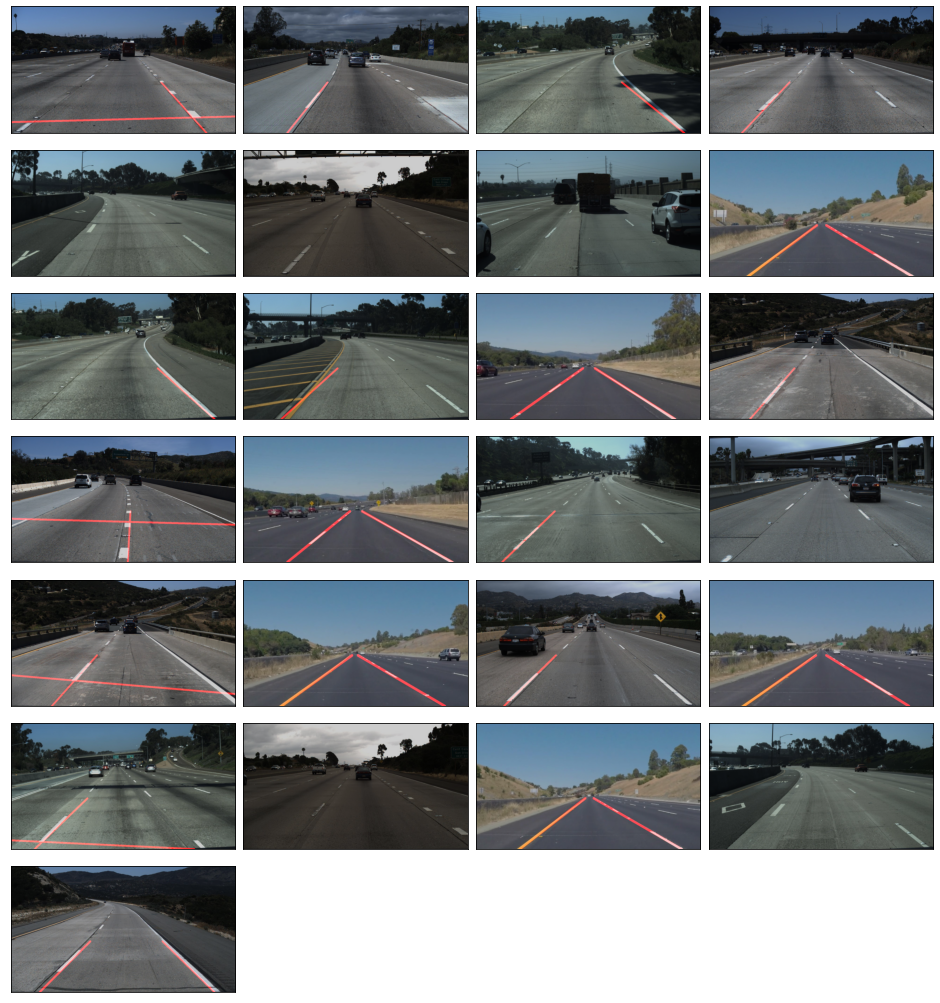

In [493]:
def lane_lines(image, lines):
    left_lane, right_lane = average_slope_intercept(lines)
    
    y1 = image.shape[0] # bottom of the image
    y2 = y1*0.6         # slightly lower than the middle

    left_line  = make_points(y1, y2, left_lane)
    right_line = make_points(y1, y2, right_lane)
    
    return left_line, right_line

    
def draw_lane_lines(image, lines, color=[255, 0, 0], thickness=10):
    # make a separate image to draw lines and combine with the orignal later
    line_image = np.zeros_like(image)
    for line in lines:
        if line is not None:
            cv2.line(line_image, *line,  color, thickness)
   
    return cv2.addWeighted(image, 0.8, line_image, 1.0, 0.0)
             
    
lane_images = []
for image, lines in zip(test_images, list_of_lines):
    lane_images.append(draw_lane_lines(image, lane_lines(image, lines)))

    
display_images(lane_images)